In [34]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble, execute, QuantumRegister
from qiskit.quantum_info.operators import Operator
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-08-11 21:00:12,375: Credentials are already in use. The existing account in the session will be replaced.


In [35]:
def oracle(nqub):
    qc = QuantumCircuit(nqub)
    cx = Operator([
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    ])
    qc.unitary(cx, [0, 1, 2, 3], label='cx')
    z_o = qc.to_gate()
    z_o.name = "z$_o$"
    return z_o
    
def diffuser(nqubits):
    list = [1, 2, 3]
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(0)
    qc.mct(list, 0)  # multi-controlled-toffoli
    qc.h(0)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

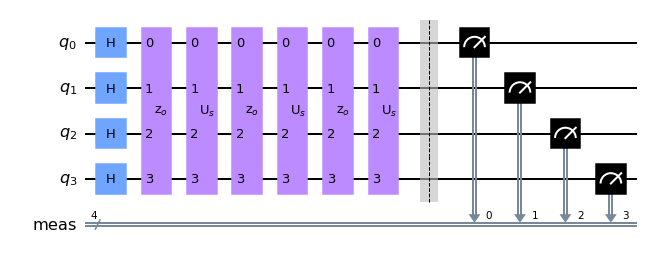

In [36]:
nqub = 4
grover = QuantumCircuit(nqub)
grover = initialize_s(grover, [0,1,2,3])
grover.append(oracle(nqub), [0,1,2,3])
grover.append(diffuser(nqub), [0,1,2,3])
grover.append(oracle(nqub), [0,1,2,3])
grover.append(diffuser(nqub), [0,1,2,3])
grover.append(oracle(nqub), [0,1,2,3])
grover.append(diffuser(nqub), [0,1,2,3])
grover.measure_all()
grover.draw()

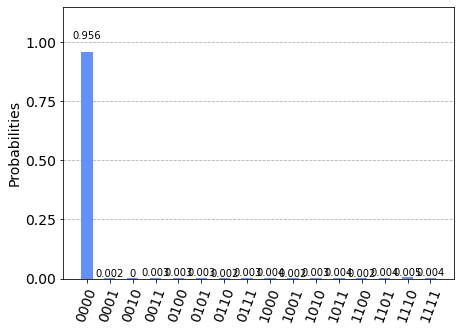

In [37]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_grover_circuit = transpile(grover, qasm_sim)
qobj = assemble(transpiled_grover_circuit)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [29]:
provider.backends(filters=lambda x: x.configuration().n_qubits >= 4
                                    and not x.configuration().simulator
                                    and x.status().operational==True)

[<IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>]

Job Status: job has successfully run


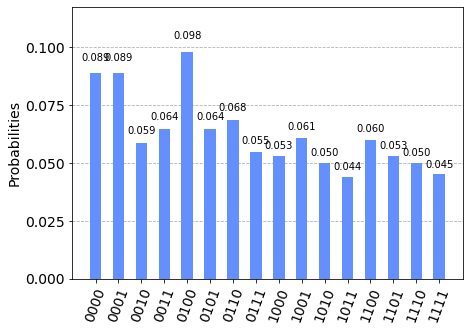

In [39]:
device = provider.get_backend('ibmq_santiago')
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover, device)
#qobj = assemble(transpiled_grover_circuit)
job = device.run(transpiled_grover_circuit)
#transpiled_grover_circuit.draw()
job_monitor(job, interval=2)
results = job.result()
answer = results.get_counts(grover)
plot_histogram(answer)